## Define data and variables

In [1]:
!curl -L -o tinyshakespear.txt https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1089k 100  1089k   0     0  9808k     0  --:--:-- --:--:-- --:--:--  9902k


In [2]:
import re

with open('tinyshakespear.txt', 'r') as f:
    corpus = f.read()

words = re.findall(r"[a-z]+", corpus.lower())
vocabulary = {x: i for i,x in  enumerate(set(words))}
reverse_index = {i: x for x, i in vocabulary.items()}

print("Corpus with characters:", len(corpus))
print("Total words in corpus:", len(words))
print("Vocabular size:", len(vocabulary))

import torch.nn.functional as F
def get_topk_similar_words(word, word_vector, k=5):
    with torch.no_grad():
        idx = vocabulary[word]
        wv = word_vector[idx]
        sim = F.cosine_similarity(word_vector, wv, dim=1)
        topk_vals, topk_idx = torch.topk(sim, k)
    
    return [(reverse_index[int(topk_idx[i])], topk_vals[i]) for i in range(k)] 

Corpus with characters: 1115394
Total words in corpus: 208503
Vocabular size: 11455


In [3]:
!rm tinyshakespear.txt

## Word2Vec

### skip-gram

$$
P(context | center) =  \frac{\exp(u_o^T v_c)}{\sum_{i \in \mathcal{V}} \exp(u_i^T v_c)}
$$

v: center

u: context

### CBOW
$$
P(center | context) = \frac{\exp(u_c^T \bar{v}_o)}{\sum_{i \in \mathcal{V}} \exp(u_i^T \bar{v}_o)}
$$

$\bar{v_o} = {v_{o_1} + \dots + v_{o_m}}/(2m)$ (context)

u: center


for skip gram we need to optimize:

$$
J(\theta) = -\frac 1T \sum_{t=1}^T \sum_{c \in context\ words} log P(c | w_t; \theta)
$$

for CBOW we can just take the log probability of the center word.


### Negative sampling
$$
 J_{neg} = - \log \sigma (u_{o}^T, v_{c}) - \sum_{k \in sampled\ words} \log \sigma (-u_{k}^T v_c)
$$

In [4]:
import numpy as np
import torch 

def get_unigram_distribution(words):
    unique_words, counts = np.unique(words, return_counts=True)
    counts = counts**(3/4)
    Z = counts.sum()
    return torch.tensor(counts / Z)


def get_windows(vocab, words, window, k_negative_samples= 0):
    """Get center words and surrounding word indices"""
    T = len(vocab)

    if k_negative_samples > 0:
        distribution = get_unigram_distribution(words)
        
    for i in range(T):
        context_ids = []
        for j in range(i-window, i+ window+1):
            if j<0 or j>= T or i == j:
                continue
            context_ids.append(vocab[words[j]])

        if k_negative_samples > 0:
            neg_indices = torch.multinomial(distribution, num_samples=k_negative_samples, replacement=True)
        else:
            neg_indices = None
            
        yield vocab[words[i]], context_ids, neg_indices
        
for idx, ctx, neg in get_windows(vocabulary, words, window=2, k_negative_samples=3):
    print(idx, ctx, neg)
    break

522 [2105, 2858] tensor([ 1356, 10166,  5336])


In [5]:
def skip_gram(U, V, center_idx: int, context_ids: list[int]):
    """P(C | w) predict context given center"""
    center = V[center_idx]

     # we need u^T v for both context windows and the whole vocab
    # dot products for all vectors in U and center
    log_probs = torch.log_softmax(U @ center, dim=0) # (vocab,)
    # now we need to do apply softmax and log
    # probs = torch.softmax(dot_products,dim=0)
    # log_probs = torch.log(probs)
    return -log_probs[context_ids].mean() #.sum()

def negative_skip_gram(U, V, center_idx: int, context_ids: list[int], neg_ids: list[int]):
    center = V[center_idx]
    context = torch.nn.functional.logsigmoid(U[context_ids] @ center)
    negative_words =  torch.nn.functional.logsigmoid(-U[neg_ids] @ center).sum(dim=0)
    return - (context + negative_words).mean()

def continuous_bow(U, V, center_idx: int, context_ids: list[int]):
    """P(W | C) Predict center given context"""
    context = V[context_ids].mean(dim=0)

    log_probs = torch.log_softmax(U @ context, dim=0) # (vocab,)

    return -log_probs[center_idx]


def negative_continuous_bow(U, V, center_idx: int, context_ids: list[int], neg_ids: list[int]):
    # instead of center we using the mean of context in V
    context = V[context_ids].mean(dim=0)
    center = torch.nn.functional.logsigmoid(U[center_idx] @ context)
    negative_words = torch.nn.functional.logsigmoid(-U[neg_ids] @ context).sum(dim=0)
    return -(center + negative_words)

Vocabulary size: 11455
Training for model: nskip


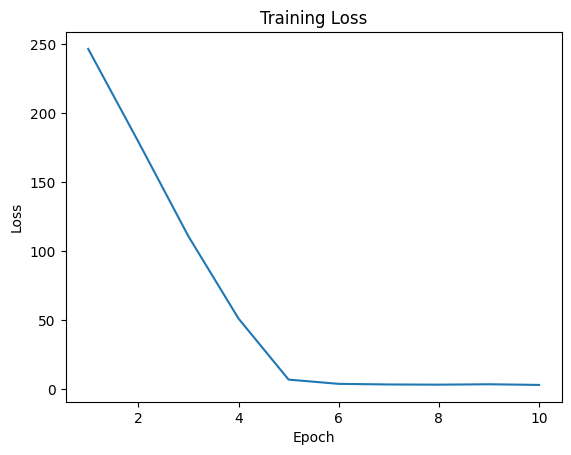

In [6]:
model = 'nskip' # 'skip', 'cbow', 'nskip', 'ncbow'
window_size = 5 # Context window left and right size
negative_samples =  10 if model.startswith('n') else 0

dimension = 100 # Embedding dim

# Training parameters
eta = 0.025
momentum= 0.001
epochs = 10
batch_size = 128

vocab_size = len(vocabulary)
print("Vocabulary size:", vocab_size)
print("Training for model:", model)

# theta <- [U, V]
# Context vectors
U = torch.rand((vocab_size, dimension), requires_grad=True)
# Center vectors; the embeddings
V = torch.rand((vocab_size, dimension), requires_grad=True)
# For CBOW U is embeddings and V is the context

# using simple SGD to update 
optimizer = torch.optim.SGD(params=[U,V], lr=eta, momentum=momentum)

losses = []
steps = []
x=0
for i in range(epochs):
    # print(f"Epoch #{i+1}...", end=" ")
    batch = []
    optimizer.zero_grad()
    for center_idx, context_ids, neg_ids in get_windows(vocabulary,words, window_size, negative_samples):
        
        center = V[center_idx]
        if model == 'skip':
            sub_sum = skip_gram(U,V, center_idx, context_ids)
        elif model == 'cbow':
            sub_sum = continuous_bow(U,V, center_idx, context_ids)
        elif model == 'nskip':
            sub_sum = negative_skip_gram(U, V, center_idx, context_ids, neg_ids)
        elif model == 'ncbow':
            sub_sum = negative_continuous_bow(U, V, center_idx, context_ids, neg_ids)
        else:
            raise Exception('unkonwn model')
            
        batch.append(sub_sum)
        break
        
        if len(batch) == batch_size:
            loss = torch.stack(batch).mean()
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            x+=1
            
            losses.append(loss.item())
            steps.append(x)
        
            batch = []

    if len(batch) > 0:
        loss = torch.stack(batch).mean()
        
        loss.backward()
        optimizer.step()
        x+=1

        losses.append(loss.item())
        steps.append(x)
    # print("Updated parameters.")
import matplotlib.pyplot as plt

epochs = list(range(1, len(losses)+1))
plt.figure()
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [7]:
# word_vec = V if model.endswith('skip') else U # (U+V)/2
get_topk_similar_words('man', V,k=10)

[('man', tensor(1.0000)),
 ('slip', tensor(0.8684)),
 ('rise', tensor(0.8540)),
 ('ah', tensor(0.8504)),
 ('send', tensor(0.8499)),
 ('assisting', tensor(0.8490)),
 ('bide', tensor(0.8443)),
 ('lightly', tensor(0.8437)),
 ('lout', tensor(0.8404)),
 ('warrior', tensor(0.8392))]

## Glove (https://nlp.stanford.edu/pubs/glove.pdf)

In [8]:
import collections

def get_windows_with_wordidx(vocab, words, window):
    """Get center words and surrounding word indices"""
    T = len(vocab)

    for i in range(T):
        cntxt_window = []
        for j in range(i-window, i+ window+1):
            if j<0 or j>= T or i == j:
                continue
            cntxt_window.append((j, vocab[words[j]]))

            
        yield (i, vocab[words[i]]), cntxt_window

def construct_coocurrence_matrix(words, vocab, window, offset=True):
    cooc = collections.defaultdict(float)

    for (center_idx, center_id), cntxt_window in get_windows_with_wordidx(vocabulary, words, window):
        for rel_idx, cntxt_id in cntxt_window:
            
            offset = abs(rel_idx - center_idx) if offset else 1
            # the number of times word j (cntxt_id) occurs in the context of word i (center_id).
            # wieighting it by offset to give more priority to closer words
            cooc[(center_id, cntxt_id)] += 1 / offset
    
    # Let Xi = ∑k Xik be the number of times any word appears in the context of word i.
    # Finally, let Pi j = P( j |i) = Xi j /Xi be the probability that word j appears with context of word i
    word_ids = reverse_index.keys()
    for i in word_ids:
        tot_sum = 0
        for j in word_ids:
            if (i,j) in cooc:
                tot_sum += cooc[(i,j)]
                
        for j in word_ids:
            if (i,j) in cooc:
                cooc[(i,j)] /= tot_sum
    
    return cooc
window = 5    
cooc = construct_coocurrence_matrix(words, vocabulary, window)
print("Total Co-occurrence pairs:", len(cooc))

Total Co-occurrence pairs: 69743


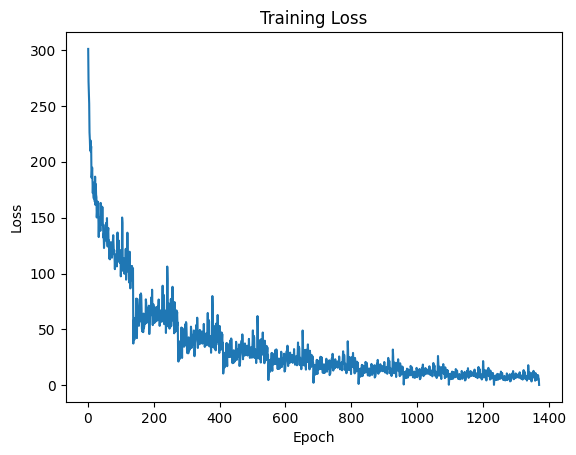

In [26]:
dimension = 50 # Embedding dim

# Training parameters
eta = 0.1
momentum= 0.001
epochs = 10
batch_size = 512

vocab_size = len(vocabulary)

U = torch.rand((vocab_size, dimension), requires_grad=True)
V = torch.rand((vocab_size, dimension), requires_grad=True)

def predicted_log_probs(i,j):
    return (U[i] * V[j]).sum(1)

def glove_loss(pred, target):
    # predicted_probs - log(probs)
    return torch.mean((pred - torch.log(target)) ** 2)

optimizer = torch.optim.SGD(params=[U,V], lr=eta)

cooc_items = list(cooc.items())
losses = []
for epoch in range(epochs):
    total_loss = 0
    for batch_start in range(0,len(cooc_items), batch_size):
        i_vec = []
        j_vec = []
        Pij_vec = []
        for (i, j), x_ij in cooc_items[batch_start:batch_start+batch_size]:
            i_vec.append(i)
            j_vec.append(i)
            Pij_vec.append(x_ij)
        
        i_vec = torch.tensor(i_vec)
        j_vec = torch.tensor(j_vec)
        p_ij = torch.tensor(Pij_vec)

        optimizer.zero_grad()
        pred = predicted_log_probs(i_vec, j_vec)
        loss = glove_loss(pred, p_ij)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    
import matplotlib.pyplot as plt

updates = list(range(1, len(losses)+1))
plt.figure()
plt.plot(updates, losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [30]:
get_topk_similar_words('men', U,k=10)

[('men', tensor(1.)),
 ('grim', tensor(0.5691)),
 ('salve', tensor(0.5639)),
 ('odor', tensor(0.5488)),
 ('glove', tensor(0.5377)),
 ('still', tensor(0.5354)),
 ('dart', tensor(0.5345)),
 ('roman', tensor(0.5333)),
 ('lovers', tensor(0.5330)),
 ('car', tensor(0.5316))]